In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from diff_music.models.ae import EncoderDecoder
import torch

from diff_music.data.dataset import PianorollDataset

from pathlib import Path

from diff_music.models.midilike_transformer import MidiLikeTransformer
from dataclasses import dataclass


@dataclass
class TrainingParams:
    batch_size: int
    learning_rate: float
    num_epochs: int
    num_workers: int
    generate_steps: int
    save_steps: int


@dataclass
class DataParams:
    max_tokens_prompt: int
    max_tokens_target: int
    path: str


training_params = TrainingParams(
    batch_size=24,
    learning_rate=1e-4,
    num_epochs=100,
    num_workers=10,
    generate_steps=200,
    save_steps=10000,
)

model_params = EncoderDecoder.Params(
    target_length=32 * 1,
    prompt_length=32 * 4,
    encoder_params=EncoderDecoder.EncoderParams(
        dim=512, num_layers=8, pitch_range=[21, 109]
    ),
    decoder_params=EncoderDecoder.DecoderParams(
        dim=512, num_layers=8, pitch_range=[21, 109]
    ),
    bottleneck_params=EncoderDecoder.BottleneckParams(
        type="vae",
        vae_params=EncoderDecoder.VaeParams(
            beta=0.0001, latent_dim=512, beta_cycle_steps=10000, beta_start_step=5000
        ),
    ),
)

data_params = DataParams(
    max_tokens_prompt=400, max_tokens_target=120, path="W:/piano-ai/pop80k_k"
)
ds = PianorollDataset(
    Path(data_params.path),
    frames_per_beat=8,
    length=model_params.prompt_length + model_params.target_length,
)

device = torch.device("cuda")


PianorollDataset initialized with 6500598 segments from 82613 songs


In [3]:
from torch.utils.data import DataLoader
from functools import partial

from diff_music.models.midilike_transformer import collate_fn_multi

my_collate_fn = partial(
    collate_fn_multi,
    max_tokens=[data_params.max_tokens_prompt, data_params.max_tokens_target],
    slices=[
        slice(0, model_params.prompt_length),
        slice(
            model_params.prompt_length,
            model_params.prompt_length + model_params.target_length,
        ),
    ],
    need_end_token=[False, True],
)
dataloader = DataLoader(
    ds,
    batch_size=training_params.batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=my_collate_fn,
    num_workers=training_params.num_workers,
    persistent_workers=training_params.num_workers > 0,
)

In [4]:
model = EncoderDecoder(params=model_params)
model.to(device)

print("params", sum(p.numel() for p in model.parameters()) / 1e6, "M")

optim = torch.optim.Adam(model.parameters(), lr=training_params.learning_rate)

params 51.704282 M


In [5]:
from datetime import datetime
import wandb

run = wandb.init(
    # Set the project where this run will be logged
    project="vqpiano",
    group="midilike-ae",
    id=datetime.now().strftime("%Y%m%d_%H%M%S"),
    # Track hyperparameters and run metadata
    config={
        "data": data_params,
        "model": model_params,
        "training": training_params,
    },
)
step = 0

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: eri24816 (tanchihpin0517-team) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [6]:
wandb.watch(
    model,
    log="all",
    log_graph=True,
)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [10]:
step

5330

In [16]:
from dataclasses import asdict
import dataclasses
from diff_music.models.representation import SymbolicRepresentation
from torch import Tensor
from tqdm import tqdm
import torch_util.wandb

for epoch in range(training_params.num_epochs):
    pbar: "tqdm[tuple[SymbolicRepresentation, SymbolicRepresentation]]" = tqdm(
        dataloader, desc=f"Epoch {epoch}"
    )
    for prompt, target in pbar:
        model.train()
        model.set_step(step)

        prompt = prompt.to(device)
        target = target.to(device)

        loss: EncoderDecoder.Loss = model(target=target, prompt=prompt)

        optim.zero_grad()
        loss.total_loss.backward()
        optim.step()

        pbar.set_postfix(
            loss=loss.total_loss.item(),
            step=step,
        )

        def iter_dataclass(dc):
            for f in dataclasses.fields(dc):
                v = getattr(dc, f.name)
                yield f.name, v

        # wandb.log({"loss": loss.total_loss.item()}, step=step)
        # for k, v in iter_dataclass(loss.bottleneck):
        #     if isinstance(v, Tensor):
        #         v = v.detach().cpu().item()
        #     k = f"bottleneck/{k}"
        #     wandb.log({k: v}, step=step)
        # for k, v in iter_dataclass(loss.reconstruction):
        #     if isinstance(v, Tensor):
        #         v = v.detach().cpu().item()
        #     k = f"reconst/{k}"
        #     wandb.log({k: v}, step=step)

        metrics = {}

        metrics["loss"] = loss.total_loss.item()

        for k, v in iter_dataclass(loss.bottleneck):
            if isinstance(v, Tensor):
                v = v.detach().cpu().item()
            metrics[f"bottleneck/{k}"] = v

        for k, v in iter_dataclass(loss.reconstruction):
            if isinstance(v, Tensor):
                v = v.detach().cpu().item()
            metrics[f"reconst/{k}"] = v

        wandb.log(metrics, step=step)

        if step % training_params.generate_steps == 0:
            model.eval()

            reconst_pr = model.reconstruct(
                target=target[0:1], prompt=prompt[0:1]
            ).to_pianoroll(model_params.decoder_params.pitch_range[0])

            gt_pr = (prompt + target).to_pianoroll(
                model_params.decoder_params.pitch_range[0]
            )

            torch_util.wandb.log_midi_as_audio(
                reconst_pr.to_midi(),
                "audio",
                step,
                soundfont_path=Path("./ignore/Essential Keys-sforzando-v9.6.sf2"),
            )
            torch_util.wandb.log_midi_as_audio(
                gt_pr.to_midi(),
                "gt_audio",
                step,
                soundfont_path=Path("./ignore/Essential Keys-sforzando-v9.6.sf2"),
            )
            gt_pr.duration = reconst_pr.duration = max(
                gt_pr.duration, reconst_pr.duration
            )
            torch_util.wandb.log_image(
                torch.cat(
                    [gt_pr.to_img_tensor(), reconst_pr.to_img_tensor()],
                    dim=0,
                ),
                "pr",
                step,
            )

            torch.cuda.empty_cache()

        step += 1
        if step == 5000:
            break

        if training_params.save_steps > 0 and step % training_params.save_steps == 0:
            torch.save(model.state_dict(), Path(wandb.run.dir) / f"{step:06d}.pth")

 58%|█████▊    | 18/31 [00:00<00:00, 78.08it/s]
32it [00:00, 84.78it/s]                        
 58%|█████▊    | 18/31 [00:00<00:00, 48.92it/s]
32it [00:00, 55.23it/s]                        
 55%|█████▍    | 17/31 [00:00<00:00, 67.11it/s]
32it [00:00, 68.65it/s]                        
 42%|████▏     | 13/31 [00:00<00:00, 127.01it/s]
32it [00:00, 125.11it/s]                        
 90%|█████████ | 28/31 [00:00<00:00, 28.18it/s]
32it [00:01, 28.93it/s]                        
 65%|██████▍   | 20/31 [00:00<00:00, 68.69it/s]
32it [00:00, 67.90it/s]                        
 61%|██████▏   | 19/31 [00:00<00:00, 84.06it/s]
32it [00:00, 67.12it/s]                        
 58%|█████▊    | 18/31 [00:00<00:00, 33.76it/s]
32it [00:00, 44.18it/s]                        
 39%|███▊      | 12/31 [00:00<00:00, 119.72it/s]
32it [00:00, 94.67it/s]                         
 35%|███▌      | 11/31 [00:00<00:00, 107.34it/s]
32it [00:00, 106.51it/s]                        
 74%|███████▍  | 23/31 [00:00<00:0

KeyboardInterrupt: 

In [20]:
target.device

device(type='cpu')

In [27]:
target = target.to(device)
prompt = prompt.to(device)

reconst_pr = model.reconstruct(target=target[1:2], prompt=prompt[1:2]).to_pianoroll(
    model_params.decoder_params.pitch_range[0]
)

gt_pr = (prompt + target)[1:2].to_pianoroll(model_params.decoder_params.pitch_range[0])

reconst_pr.to_midi("reconstruct.mid")
gt_pr.to_midi("gt.mid")


32it [00:00, 94.88it/s]                        


ticks per beat: 480
max tick: 0
tempo changes: 1
time sig: 0
key sig: 0
markers: 0
lyrics: False
instruments: 1

In [14]:
torch.save(model.state_dict(), Path(wandb.run.dir) / f"{step:06d}.pth")

In [ ]:
for k, v in iter_dataclass(loss.bottleneck):
    print(k, v)

total_loss tensor(0.0471, device='cuda:0', grad_fn=<MulBackward0>)
kl_loss tensor(0.4315, device='cuda:0', grad_fn=<MeanBackward0>)
beta 0.1092


In [12]:
import os

os.tx

In [ ]:
model(target=target, prompt=prompt)

MidiLikeTransformer.Loss(token_type_loss=tensor(0.5023, device='cuda:0', grad_fn=<NllLoss2DBackward0>), pitch_loss=tensor(0.9858, device='cuda:0', grad_fn=<MeanBackward0>), velocity_loss=tensor(1.1485, device='cuda:0', grad_fn=<MeanBackward0>), total_loss=tensor(2.6365, device='cuda:0', grad_fn=<AddBackward0>), pitch_acc=0.0357142873108387, velocity_acc=0.010119047947227955, token_type_acc=0.574404776096344)

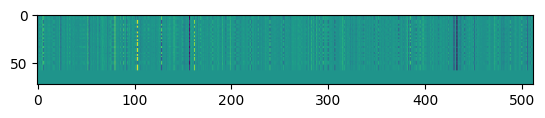

In [ ]:
from matplotlib import pyplot as plt


plt.imshow(torch.x[0].detach().cpu())

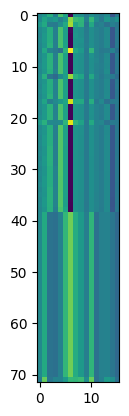

In [ ]:
model.eval()
x = torch.randn(1, 10, 512).to(device)

src_key_padding_mask = torch.zeros(1, 10).to(device)
src_key_padding_mask[:, 5:] = 0

src_key_padding_mask = src_key_padding_mask.log()

# out = model.encoder.transformer(
#     x, mask=None, src_key_padding_mask=src_key_padding_mask, is_causal=False
# )
torch.km[:, -1] = 0
out = model.encoder.transformer(
    torch.x, mask=None, src_key_padding_mask=torch.km, is_causal=False
)

plt.imshow(out[0, :, :16].detach().cpu())


In [ ]:
torch.km

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, 0.]],
       device='cuda:0')

In [ ]:
model.eval()
# g1 = prompt[3:4] + target[3:4]
# r = model.reconstruct(target=target[3:4], prompt=prompt[3:4])
# r.to_pianoroll(model_params.decoder_params.pitch_range[0]).to_midi("sample.mid")
# g1.to_pianoroll(model_params.decoder_params.pitch_range[0]).to_midi("sample2.mid")
p1 = prompt[0:1]
p2 = prompt[1:2]
t1 = target[0:1]
t2 = target[1:2]


rec11 = model.reconstruct(target=t1, prompt=p1)
rec22 = model.reconstruct(target=t2, prompt=p2)
rec21 = model.reconstruct(target=t2, prompt=p1)
rec12 = model.reconstruct(target=t1, prompt=p2)

gt1 = p1 + t1
gt2 = p2 + t2

(gt1 + gt2 + rec11 + rec22 + rec21 + rec12).to_pianoroll(
    model_params.decoder_params.pitch_range[0]
).to_midi("reconstruct.mid")


 35%|███▌      | 11/31 [00:00<00:00, 45.82it/s]
32it [00:00, 82.68it/s]                        

 29%|██▉       | 9/31 [00:00<00:00, 74.38it/s]
32it [00:00, 99.50it/s]                         

 68%|██████▊   | 21/31 [00:00<00:00, 96.45it/s]
32it [00:00, 94.72it/s]                        

 42%|████▏     | 13/31 [00:00<00:00, 129.94it/s]
32it [00:00, 145.49it/s]                        


ticks per beat: 480
max tick: 0
tempo changes: 1
time sig: 0
key sig: 0
markers: 0
lyrics: False
instruments: 1

In [37]:
model.load_state_dict(
    torch.load(r"wandb\run-20250319_171116-20250319_171115\files\020000.pth")
)

<All keys matched successfully>

In [17]:
step

3706

In [18]:
torch_util.wandb.log_midi_as_audio(
    reconst_pr.to_midi(),
    "audio",
    step,
    soundfont_path=Path("./ignore/Essential Keys-sforzando-v9.6.sf2"),
)


In [ ]:
model.eval()
reconst_pr = model.sample_midi(model_params.max_len)
torch_util.wandb.log_midi_as_audio(
    reconst_pr.to_midi(),
    "audio",
    step,
    soundfont_path=Path("./ignore/Essential Keys-sforzando-v9.6.sf2"),
)
torch_util.wandb.log_image(reconst_pr.to_tensor().t().flip(0), "pr", step)


100%|██████████| 256/256 [00:05<00:00, 46.86it/s]


In [8]:
step

548

In [10]:
reconst_pr = model.sample_midi(256)

100%|██████████| 256/256 [00:03<00:00, 78.72it/s]


In [ ]:
from torch_util.os import run_command

audio_path = "a.wav"
# pr.to_midi('sample.mid')
f"fluidsynth -R1 -F {audio_path} ./ignore/Essential Keys-sforzando-v9.6.sf2 sample.mid"

'fluidsynth -R1 -F a.wav ./ignore/Essential Keys-sforzando-v9.6.sf2 sample.mid'